# Optimal Portfolio Liquidation in Dark Pool

Lets start with the simple ploicy that we will distribute the orders equally throughtout time and also in market order and dark pool order,

i.e. if $ X_0 $ is the amount of stocks available to liquidate we will divide it into equal blocks in time i.e. $ x_t = X_0/T $ and $ u_t = x_t/2 $ and $ z_t = x_t/2 $.

We will then generate the sample paths and the total reward accumultaed using this policy. Based on that we will update the policy and repeat above.

Again lets assume following dynamics of the market (update later)

State of the system is described by following variables:

$ X_t $ : amount of stocks available to liquidiate at time $t$.

$ p_t $ : price of the stock at time $t$.

$ y_t $ : executed stocks in dark pool at time $t-1$.

Action set is given by 

$x_t$ : Market Order and $z_t$ : Dark Order

Assume the following reward function 
$ c_t(X_t, p_t, y_t) = p_t \cdot x_t + d_t \cdot min(z_t,y_t) $

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# simple policy as discussed above 
policy = [[50,50] for i in range(10)]

In [3]:
#generate sample path using above policy and dynamics as given
state = [0, 0.0, 0]

In [46]:
def getMarketPrice(x_t, p_t):
    #print("in market", x_t)
    if x_t < 4 or p_t < 3.0:
        return p_t
    elif x_t <= 40:
        return p_t*(1-0.000008*x_t)
    else:
        return p_t*(1- 0.01*np.log(x_t))

In [5]:
def getDarkPrice(z_t, p_t):
    #print("in dark", x_t)
    d_t = max(min(p_t+np.random.normal(0,1), 100), 0)
    return d_t

In [6]:
# Generate 1000 samples and stote the results
# since we are assuming a finite horizon problem, lets consider the time also as feature

samples = [[0, 0, 0.0, 0 , 0.0] for i in range(10000)]
j = 0
for i in range(909):
    X_t = int(np.random.random()*1000)
    y_t = np.random.randint(0, 100)
    p_t = np.random.random()*100
    value = 0.0
    t = 0
    # loop to visit sample path and calculate reward
    while X_t >0 and t < 10:
        #for t in range(10):
        samples[j][0] = X_t
        samples[j][1] = y_t
        samples[j][2] = p_t
        samples[j][3] = t
        x_t = int(X_t/(2*(10-t)))
        p_t_ = getMarketPrice(x_t, p_t)
        y_t = np.random.randint(0, 100)
        d_t = getDarkPrice(x_t, p_t)
        value = value + p_t_*x_t + d_t*min(y_t, x_t)
        samples[j][4] = value
        p_t = p_t_ + np.random.normal(1,1)
        X_t = X_t - (x_t + min(x_t, y_t))
        t = t + 1
        j = j + 1
    samples[j][0] = X_t
    samples[j][1] = y_t
    samples[j][2] = p_t
    samples[j][3] = t
    value = value + X_t*getMarketPrice(X_t, p_t)
    samples[j][4] = value
    #print(value)
    j = j + 1
    #print(j)

In [7]:
samples = np.array(samples)

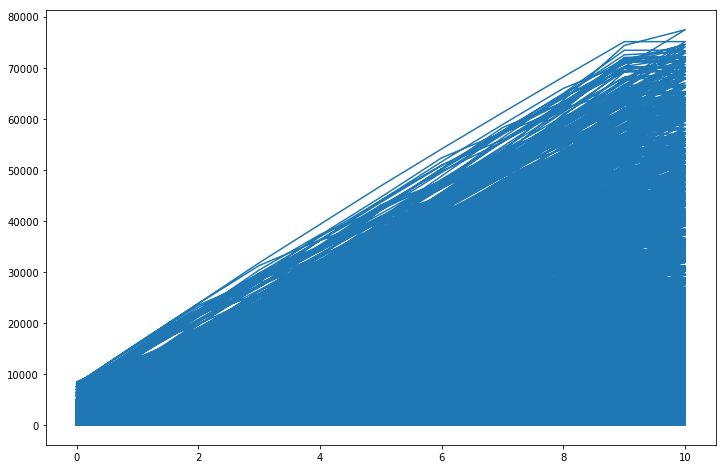

In [8]:
plt.figure(figsize=(12,8))
plt.plot(samples[:,3],samples[:,4])

In [68]:
X_t = 1000
y_t = np.random.randint(0, 100)
p_t = np.random.random()*100
value = 0.0
print(p_t, value)
#samples[i][0] = X_t
#samples[i][1] = y_t
#samples[i][2] = p_t
    # loop to visit sample path and calculate reward
while X_t > 0:
    x_t = int(X_t/(2*(10-t)))
    p_t_ = getMarketPrice(x_t, p_t)
    y_t = np.random.randint(0, 100)
    d_t = getDarkPrice(x_t, p_t)
    val = p_t_*x_t + d_t*min(y_t, x_t)
    value = value + val
    p_t = p_t_ + np.random.normal(1,1)
    X_t = X_t - (x_t + min(x_t, y_t))
    #samples[i][3] = value
    print(p_t_, d_t, x_t, y_t, val)

11.093292387472275 0.0
10.6593202372 10.48718813869644 50 60 1057.3254188
11.8467210009 12.9440479141 50 14 773.552720845
10.5739274407 12.2483912354 52 49 1150.01539745
9.52433160596 10.6379429351 52 76 1048.43827614
9.76780168715 10.5970158449 52 87 1058.97051167
10.0261193432 10.4915884449 52 68 1066.92080498
12.218233794 13.9852353771 52 33 1096.86092474
16.2689562141 17.3111498186 56 42 1638.12984037
17.1002584293 17.5887921106 60 62 2081.34303239
15.6938254429 16.6920727078 60 32 1475.77585323


In [9]:
# once samples have been generated, fit the linear regression model or better neural network
import sklearn.neural_network as net

In [10]:
mlp = net.MLPRegressor(hidden_layer_sizes=4, max_iter=10000)

In [11]:
mlp.fit(samples[:,[0,1,2,3]], samples[:,4])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=4, learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [12]:
mlp.score(samples[:,[0,1,2,3]], samples[:,4], sample_weight=None)

0.7157589662950683

In [13]:
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 4,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 10000,
 'momentum': 0.9,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

after every fit, we need to update the policy and refit the function and keep doing that
We will be considering Gambel distribution for dark pool, cdf of whihc is given as
### $$F(x;\mu,\beta) = e^{-e^{\frac{-(x-\mu)}{\beta}}}$$
and probability density function is given by
### $$ f(x;\mu, \beta) = e^{-(x+e^{-x})} $$
Mean is given as 
### $$ E{x} = \mu + \beta\gamma $$ 
where $\gamma$ is Euler–Mascheroni constant which is equal to $0.57721566490153286060651209008240243104215933593992$ to 50 decimal places.

For our purpose we consider that the value of $\mu$ is same as $y_{t-1}$ and value of $\beta$ is taken as some parametric form based on price and available stocks.

properties of beta should be,
1. Should increase with price in market order.
2. Should increase with the value of $y_t $.
3. Should increase with value of $X_t$.
5. We dont want beta to be larger than 10.


# $$ \beta_t = \log\frac{k_tp_tX_t}{10(z_t-y_t)}$$

In [160]:
# lets draw the above beta function for some value of p_t and X_t
p_t = 95.5
X_t = 1000
z_t = 89
y_t = 65
k_t = [i for i in range(1,20)]
beta = [np.log((k*p_t*0.1*X_t)/((z_t-y_t/2))) for k in k_t]

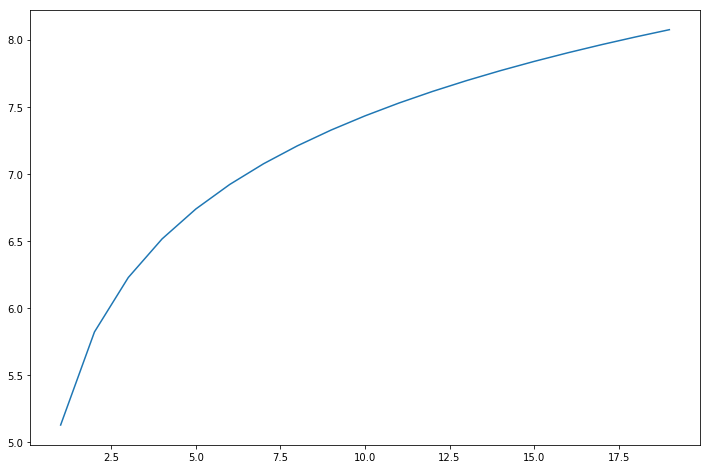

In [161]:
plt.figure(figsize=(12,8))
plt.plot(k_t, beta)

We will consider the policy as follows, we apply to dark pool, the mean value based on Gambell distribution and for the market orders we define a parametric function based on time, availbale stocks and price.

Properties of the function should be,
1. It should be inversely proprtional to change in price.
2. It should be increase as time increases.
3. More stocks left, more should be applied.

## $$ x_t = (1-e^{-\sqrt{\frac{k}{T-t}}})\frac{p_tX_t}{100}$$

In [231]:
p_t = 6.7
X_t = 1000
T = 10
t = 5
y = [i for i in range(100)]
x_t = [10*p_t*(1- np.exp(-1* np.sqrt(y_/9.0))) for y_ in y]

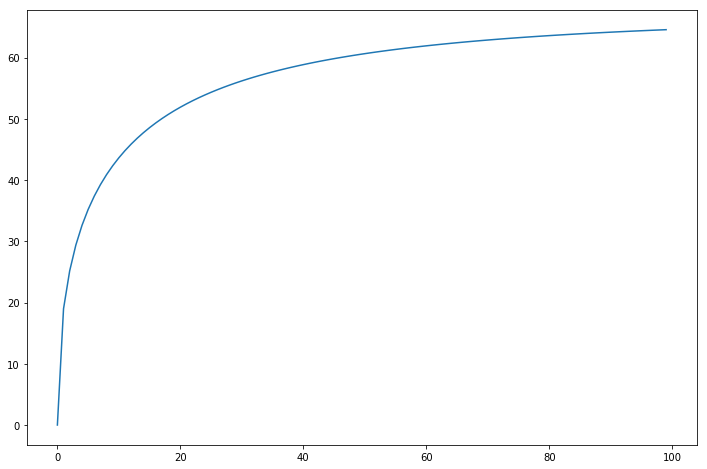

In [232]:
plt.figure(figsize=(12,8))
plt.plot(y,x_t)

In [227]:
# now based on the above values which was approximated, we need to update the policy.
# lets find out one step policy first and see if it works or fails
X_t = 1000
z_t = np.random.randint(0, 100)
y_t = min(np.random.randint(0, 100), z_t)
p_t = np.random.random()*100

t = 1
gamma = 0.577
maximum = 0.0
for i in range(1, 10):
    if z_t == y_t:
        beta = 10
    else:
        beta = np.log((i*p_t*0.1*X_t)/((z_t-y_t/2)))
    #print(beta)
    z_t = int(y_t + gamma*beta)
    X_t = X_t - z_t
    for k in range(1,20):
        x_t = (X_t/100)*p_t*(1- np.exp(-1* np.sqrt(k/t)))
        p_t = getMarketPrice(x_t, p_t)
        d_t = getDarkPrice(z_t, p_t)
        y_t = min(np.random.randint(0, 100), z_t)
        if z_t > y_t:
            X_t = int(X_t + (z_t-y_t) - x_t)
        value = x_t*p_t + min(z_t, y_t)*d_t + mlp.predict(np.array([X_t, y_t, p_t, 10-t]).reshape(1,-1))[0]
        
        #print(value)
        if value > maximum:
            maximum = value
            k_t = k
            j_t = i
    print(maximum, k_t, j_t, X_t)
            

46526.3124483 8 1 978
46526.3124483 8 1 1048
46526.3124483 8 1 1062
46526.3124483 8 1 1057
50222.4866439 12 5 1172
50222.4866439 12 5 1109
50222.4866439 12 5 1045
50222.4866439 12 5 826
50222.4866439 12 5 725


In [168]:
val = mlp.predict(np.array([1000, 32, 56.6, 9]).reshape(1,-1))